In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_moons
from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

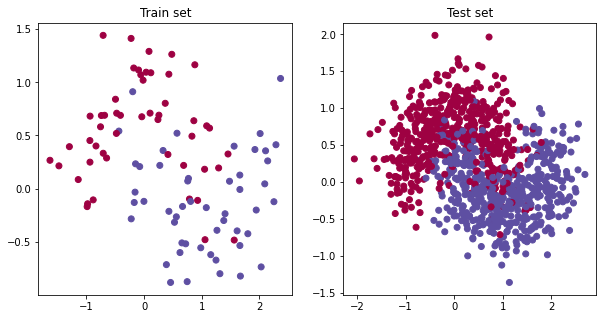

In [5]:
np.random.seed(16)
tr_x, tr_y = make_moons(100, noise=0.3)
ts_x, ts_y = make_moons(1000, noise=0.3)

xx, yy = np.meshgrid(np.arange(-2, 3, 0.05), np.arange(-1.5, 2.0, 0.05))
zz = np.concatenate([xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(tr_x[:,0], tr_x[:,1], c=tr_y, cmap=plt.cm.Spectral)
axs[0].set_title('Train set')
axs[1].scatter(ts_x[:,0], ts_x[:,1], c=ts_y, cmap=plt.cm.Spectral)
axs[1].set_title('Test set')
plt.show()

# Bagging

Works well for overfitting (SVM-C values high), not underfitting (SVM-C values low)

Bagging is the process of sub-sampling training data to improve generalization performance of a single type of classifier. The idea is that if there are particular areas of the data which a single classifier might overfit to, random bootstrap resamples of the dataset may only sometimes include that data or weight it differently, encouraging those areas with confident-but-wrong classifications to become de-emphasized.

Points about bagging:

- This procedure is basically a wrapper on any other classifier you're working with. Wherever you can use a Classifier(), you can use Bag(Classifier()) instead interchangeably.

- The subsets of the training data will overlap - you're not splitting the data, you're resampling.

- The hyperparameters of the classifier don't change from subsample to subsample - that would be a more general form of ensembling method.

- Bagging directly multiplies both the training and inference costs - generally by 5x or 10x. The effect is usually subtle - don't expect to get more than a few percent improvement in general from this.

- This is a bias-reduction technique, so if you're variance-limited it's not going to help (that is, this is good for when you're overfitting but doesn't do anything if you're underfitting).

### Example: 2D dataset 

This example is just to show the softening of an overfit classifier - I actually can't get an advantage from bagging in this case, so I'm intentionally going to overfit to show the effect.

Afterwards we'll look at a real dataset to observe the impact on accuracy.

In [6]:
def plot_results(clf_1, clf_2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # SVC
    time_now = time.time()
    clf_1.fit(tr_x, tr_y)
    p = clf_1.predict_proba(zz)
    p = p.reshape((xx.shape[0], xx.shape[1], 2))
    cax = axs[0].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
    cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[0])
    axs[0].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
    axs[0].set_title(f'Accuracy: {clf_1.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec')

    # Bagging SVC
    time_now = time.time()
    clf_2.fit(tr_x, tr_y)
    p = clf_2.predict_proba(zz)
    p = p.reshape((xx.shape[0], xx.shape[1], 2))
    cax = axs[1].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
    cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[1])
    axs[1].scatter(tr_x[:,0], tr_x[:,1], c=tr_y, cmap=plt.cm.Spectral)
    axs[1].set_title(f'Accuracy: {clf_2.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec')

    plt.tight_layout()

In [4]:
# Bagging helps us recover from the overfit at 5x the cost

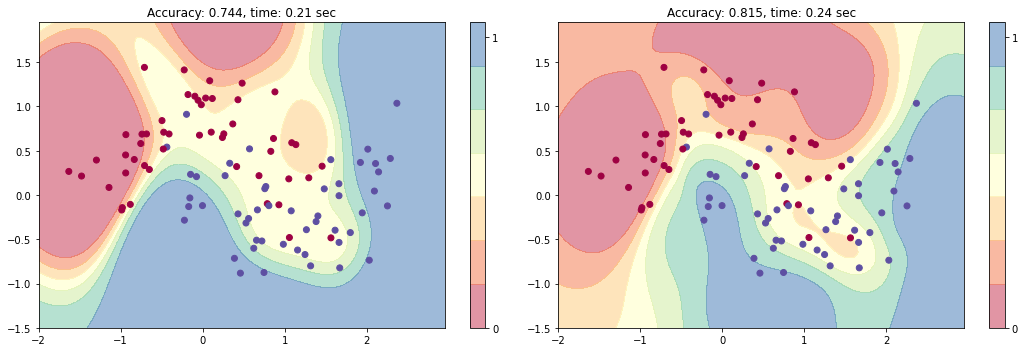

In [5]:
clf_1 = SVC(C=100000, gamma='scale', probability=True)
clf_2 = BaggingClassifier(SVC(C=100000, gamma='scale', probability=True), n_estimators=5, max_samples=1.0)
plot_results(clf_1, clf_2)

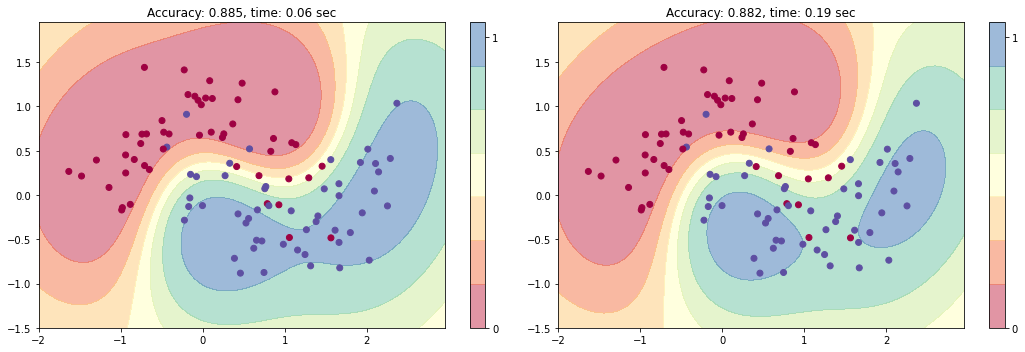

In [6]:
clf_1 = SVC(C=1, gamma='scale', probability=True)
clf_2 = BaggingClassifier(SVC(C=1, gamma='scale', probability=True), n_estimators=5, max_samples=1.0)
plot_results(clf_1, clf_2)

### Decision trees

Same as the above example, but with a classifier that is much more biased for this kind of data: decision trees.

What we're doing here moves in the direction of the difference between decision trees and random forests.

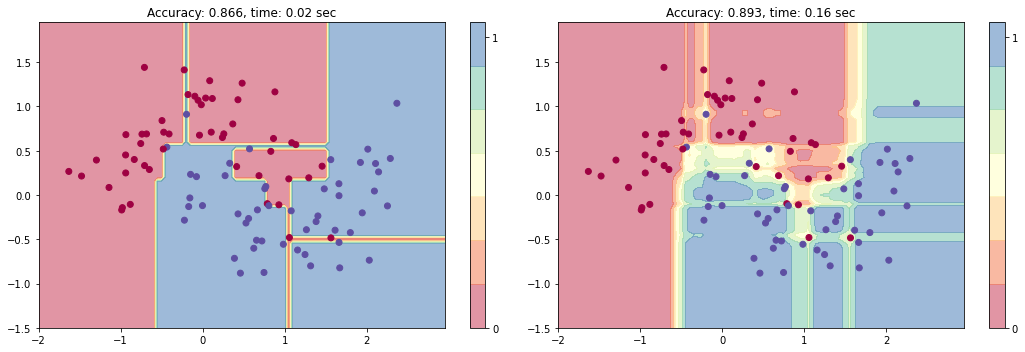

In [6]:
clf_1 = DecisionTreeClassifier()
clf_2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=1.0)
plot_results(clf_1, clf_2)

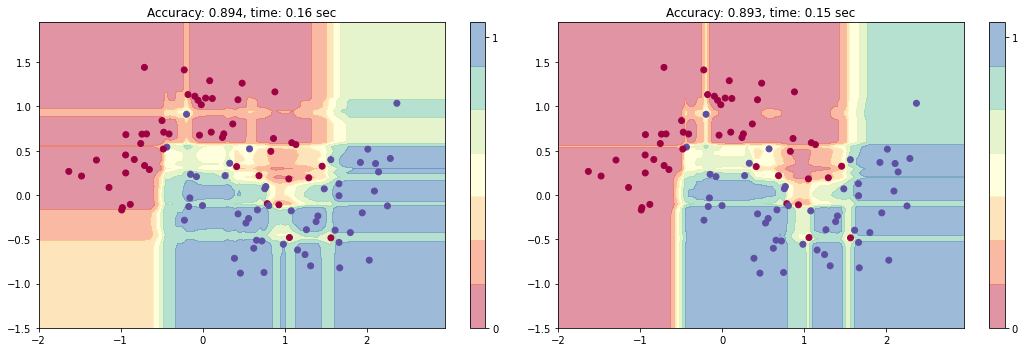

In [15]:
clf_1 = RandomForestClassifier()
clf_2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=1.0)
plot_results(clf_1, clf_2)

### Linear models

Bagging something like logistic regression technically allows for non-linear fits, but don't expect miracles. At best, you'll get better uncertainty estimates.

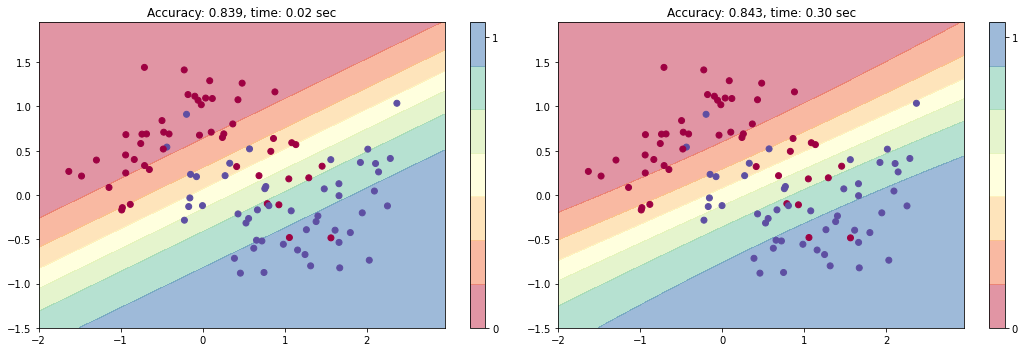

In [8]:
clf_1 = LogisticRegression(C=10000, solver='lbfgs')
clf_2 = BaggingClassifier(LogisticRegression(C=10000, solver='lbfgs'), n_estimators=100, max_samples=1.0)
plot_results(clf_1, clf_2)

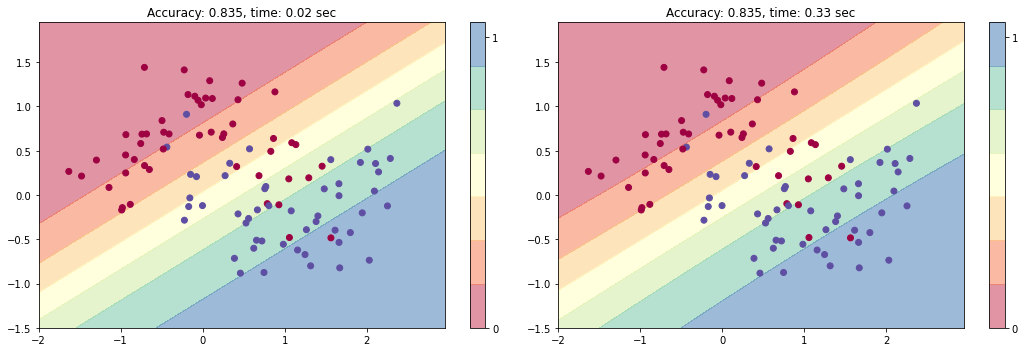

In [9]:
clf_1 = LogisticRegression()
clf_2 = BaggingClassifier(LogisticRegression(), n_estimators=100, max_samples=1.0)
plot_results(clf_1, clf_2)

### Bagging as a general wrapper

To show how general bagging is, we're going to implement a neural network in PyTorch and use Scikit-Learn's bagging wrapper on it. To do this, we need to wrap the network in a `sklearn.base.BaseEstimator` object implementing `fit`, `predict_proba`, `get_params`, and `set_params`.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 2)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
    
    def forward(self, x):
        z = F.leaky_relu(self.l1(x))
        z = F.leaky_relu(self.l2(z))
        z = F.leaky_relu(self.l3(z))
        z = F.log_softmax(self.l4(z),1)
        return z

class NetworkClassifier(BaseEstimator):
    def __init__(self):
        super().__init__()
        self.classes_ = np.array([0, 1])
        self.net = Net()
                
    def get_params(self, deep=True):        
        return {}

    def set_params(self, **parameters):
        return self
    
    def fit(self, x, y, sample_weight = None):
        self.net = Net()        
        idx = torch.arange(x.shape[0]).long()
        yy = torch.LongTensor(y)
        
        if sample_weight is not None:  # Useful for the AdaBoost
            w = torch.FloatTensor(sample_weight)
        else:
            w = torch.ones(x.shape[0])
            
        for i in range(150):
            self.net.optim.zero_grad()
            p = self.net.forward(torch.FloatTensor(x))
            loss = -torch.mean(w * p[idx, yy[idx]])
            loss.backward()
            self.net.optim.step()
    
    def predict_proba(self, x):
        p = np.exp(self.net.forward(torch.FloatTensor(x)).cpu().detach().numpy())
        return p
    
    def score(self, x, y):
        p = self.predict_proba(x)
        p = np.argmax(p,axis=1)
        
        return np.mean(p==y)

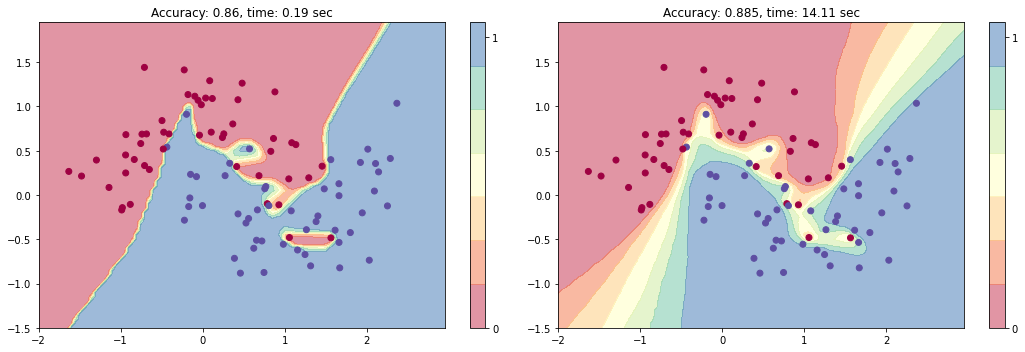

In [9]:
clf_1 = NetworkClassifier()
clf_2 = BaggingClassifier(NetworkClassifier(), n_estimators=100, max_samples=1.0)
plot_results(clf_1, clf_2)